# Подготовка

In [2]:
import os
import random
import time

import torch
from torch import nn

import torchvision
from torchvision import datasets, models, transforms

#import tqdm
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

In [3]:
print(f'torch.__version__ = {torch.__version__}')
print(f'torchvision.__version__ = {torchvision.__version__}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device} \n')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(f'{gpu_info}')

torch.__version__ = 2.3.1+cu121
torchvision.__version__ = 0.18.1+cu121
device = cuda 

Wed Aug  7 19:59:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |     

In [4]:
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

seed_everything(42)

In [5]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_batch(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Create a grid from the images and show them
    img_grid = torchvision.utils.make_grid(images)
    matplotlib_imshow(img_grid, one_channel=False)

In [6]:
def set_requires_grad(model, value=False):
    for param in model.parameters():
        param.requires_grad = value

In [7]:
# labels for Imagenette
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

def label_func(fname):
    return lbl_dict[parent_label(fname)]

# Основная часть

1. Скачать датасет ImageNette: https://github.com/fastai/imagenette (ImageNette это подвыборка из 10 классов датасета ImageNet).

In [9]:
dowload_needed = True

train_transforms =  transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

val_transforms =  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])


train_set = datasets.Imagenette("./data", split="train", download=dowload_needed, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

val_set = datasets.Imagenette("./data", split="val", download=False, transform=val_transforms)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)



100%|██████████| 1557161267/1557161267 [00:55<00:00, 28041460.61it/s]


Extracting ./data/imagenette2.tgz to ./data


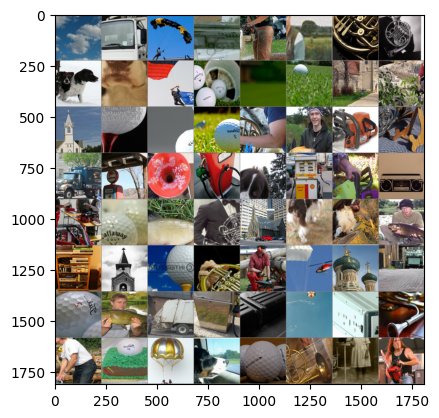

In [10]:
show_batch(train_loader)

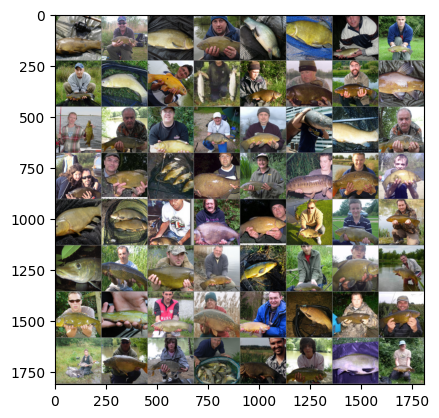

In [11]:
show_batch(val_loader)

2. Взять предобученную на обычном ImageNet модель (например, ResNet18) и заменить число классов на 10.

In [12]:
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


In [13]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [14]:
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [15]:
weights.meta['categories'][:10]

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

In [16]:
# заменяем слой классификации на 10 классов
num_classes = 10
num_in_features = model.fc.in_features

set_requires_grad(model, False)
model.fc = nn.Linear(num_in_features, num_classes)

In [17]:
model.fc

Linear(in_features=512, out_features=10, bias=True)


3. Дообучить модель на 10 классах ImageNette и замерить точность (это точность будет считаться базовой). Можно обучить как всю модель, так и только последний слой.

In [18]:
def train_model(model, dataloaders, criterion, optimizer, phases, num_epochs=3):
    start_time = time.time()

    acc_history = {k: list() for k in phases}
    loss_history = {k: list() for k in phases}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = len(dataloaders[phase])
            for inputs, labels in tqdm(dataloaders[phase], total=n_batches):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double()
            epoch_acc /= len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))
            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))

    return model, acc_history

Дообучение модели - только последний слой

In [19]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

set_requires_grad(model, False)
set_requires_grad(model.fc, True)

loaders = {'train': train_loader, 'val': val_loader}

model = model.to(device)
train_model(model, loaders, criterion, optimizer, phases=['train', 'val'], num_epochs=3)

Epoch 0/2
----------


  0%|          | 0/148 [00:00<?, ?it/s]

train Loss: 0.3330 Acc: 0.8991


  0%|          | 0/62 [00:00<?, ?it/s]

val Loss: 0.0671 Acc: 0.9783

Epoch 1/2
----------


  0%|          | 0/148 [00:00<?, ?it/s]

train Loss: 0.2233 Acc: 0.9341


  0%|          | 0/62 [00:00<?, ?it/s]

val Loss: 0.0689 Acc: 0.9786

Epoch 2/2
----------


  0%|          | 0/148 [00:00<?, ?it/s]

train Loss: 0.2149 Acc: 0.9374


  0%|          | 0/62 [00:00<?, ?it/s]

val Loss: 0.0467 Acc: 0.9855

Training complete in 4m 46s


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

4. Сохранить последний слой на 10 классов (слой классификации).

In [20]:
torch.save(model.fc.state_dict(), 'imagenette_fc_weights.pth')

5. Используя код с лекции дообучить модель классифицировать датасет CIFAR10.

In [21]:
trainset_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=64, shuffle=True, num_workers=2)

testset_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=64, shuffle=False, num_workers=2)

loaders_cifar = {'train': trainloader_cifar, 'val': testloader_cifar}
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 43784460.89it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [22]:
set_requires_grad(model, True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

model = model.to(device)
train_model(model, loaders_cifar, criterion, optimizer, phases=['train', 'val'], num_epochs=3)

Epoch 0/2
----------


  0%|          | 0/782 [00:00<?, ?it/s]

train Loss: 2.0352 Acc: 0.3021


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 1.5341 Acc: 0.4446

Epoch 1/2
----------


  0%|          | 0/782 [00:00<?, ?it/s]

train Loss: 1.2510 Acc: 0.5510


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 1.0727 Acc: 0.6261

Epoch 2/2
----------


  0%|          | 0/782 [00:00<?, ?it/s]

train Loss: 0.8430 Acc: 0.7044


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.9010 Acc: 0.6920

Training complete in 11m 42s


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

6. Вернуть оригинальный последний слой модели и проверить качество на ImageNette и сравнить с базовой точностью.

In [23]:
model.fc.load_state_dict(torch.load('imagenette_fc_weights.pth'))

<All keys matched successfully>

In [25]:
train_model(model, loaders, criterion, optimizer, phases=['val'], num_epochs=3)

Epoch 0/2
----------


  0%|          | 0/62 [00:00<?, ?it/s]

val Loss: 3.3361 Acc: 0.0764

Epoch 1/2
----------


  0%|          | 0/62 [00:00<?, ?it/s]

val Loss: 3.3361 Acc: 0.0764

Epoch 2/2
----------


  0%|          | 0/62 [00:00<?, ?it/s]

val Loss: 3.3361 Acc: 0.0764

Training complete in 1m 28s


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

7. Дообучить только последний слой (отключить градиент для всех слоев кроме последнего) на ImageNette и проверить удалось ли добиться исходного качества.

In [26]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

set_requires_grad(model, False)
set_requires_grad(model.fc, True)

loaders = {'train': train_loader, 'val': val_loader}

model = model.to(device)
train_model(model, loaders, criterion, optimizer, phases=['train', 'val'], num_epochs=3)

Epoch 0/2
----------


  0%|          | 0/148 [00:00<?, ?it/s]

train Loss: 1.7451 Acc: 0.3970


  0%|          | 0/62 [00:00<?, ?it/s]

val Loss: 1.3718 Acc: 0.5376

Epoch 1/2
----------


  0%|          | 0/148 [00:00<?, ?it/s]

train Loss: 1.5408 Acc: 0.4799


  0%|          | 0/62 [00:00<?, ?it/s]

val Loss: 1.3435 Acc: 0.5503

Epoch 2/2
----------


  0%|          | 0/148 [00:00<?, ?it/s]

train Loss: 1.4800 Acc: 0.5015


  0%|          | 0/62 [00:00<?, ?it/s]

val Loss: 1.2622 Acc: 0.5837

Training complete in 4m 53s


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

8. Сделать выводы.

# Выводы


1. Метрики:
- обучение последнего слоя (fc) ResNet18 на ImageNette  
```
train Loss: 0.2149 Acc: 0.9374  
val   Loss: 0.0467 Acc: 0.9855
```

- дообучение модели на CIFAR10
```
train Loss: 0.8430 Acc: 0.7044
val   Loss: 0.9010 Acc: 0.6920
```

- загрузка весов последнего слоя (fc) от ImageNette для сети, обученной на CIFAR10, inference на ImageNette  
```
val   Loss: 3.3361 Acc: 0.0764  
```

- повторное обучение последнего слоя (fc) на ImageNette  
```
train Loss: 1.4800 Acc: 0.5015  
val   Loss: 1.2622 Acc: 0.5837
```

2. Наблюдения:
- если дообучить слой классификатора на сабсете датасета, на котором обучалась исходная модель (ImageNette - сабсет ImageNet, на котором обучалась ResNet18 дефолтные веса от которой использовались), то получается очень высокая точность классификации
- если дообучить модель на другой датасет, то можно получить относительно высокую точность (0.69 для CIFAR10 на модели, обученной на ImageNet + ImageNette)
- если для модели обученной на CIFAR заменить слой классификатора на обученный для модели ImageNette, то ничего хорошего не получается. Точность 0.07 - не классифицировал ничего.
- повторное обучение слоя классификатора на ImageNette для сети обученной на CIFAR10 не дает приемлемой точности классификации (0.58 на валидации маловато)

3. Выводы:
- для finetuning-а нужно выбирать модели, предобученные на датасете, максимально близком к целевому датасету
- сохранение слоя классификатора не всегда работает
- лучше переобучить сеть на нужный датасет целиком, чем подменять только слой классификатора